## Predictive Model
For the final predictive models of the data set, we use the ‘processed_dataset.csv’ created in the descriptive analysis section. This dataset would contain the pre-cleaned data for missing values in order to avoid repeating the same code. To make sure the predictive models work, the data has to be pre-processed further.


### Import libraries

NOTE: To run all the libraries correctly, it is assumed that the XGBoost package has been installed into the anaconda environment beforehand.

Python:
pip install xgboost

Anaconda:
conda install -c conda-forge py-xgboost

In [1]:
#Import required packages
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import datetime

In [2]:
#Import the models/tools for analysis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Data preprocessing: feature engineering & selection

First of all, since machine learning algorithms do not support dates/time, all of the dates have to be converted into integers. For this reason, every date is converted into years instead since the days/months do not prove to be significant for our analysis and predictive model. Afterwards, we split up the ‘category_list’ column into separate rows, so each category is assigned their own values for the predictive modeling and the model can compute it. The dataset contains a lot of columns which have non-numerical values and cannot be used in the regression analysis, which is why One-hot encoding is performed for the conversion of categorical data into numerical data. At the end, several columns were dropped from the training/testing data set since they do not play any significant role in the performance of the predictive model (‘permalink’, ‘name’, ‘homepage_url’).

In [3]:
#Import the pre-processed dataset
training = pd.read_csv("../data/processed_dataset.csv")
training.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30,2012-06-30
1,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,Not Available,Tallinn,Tallinn,1,2012-10-26,2012-08-09,2012-08-09
2,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,Not Available,London,London,1,2011-04-01,2011-04-01,2011-04-01
3,/organization/r-ranch-and-mine,-R- Ranch and Mine,not available,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2,2014-01-01,2014-08-17,2014-09-26
4,/organization/club-domains,.Club Domains,http://nic.club/,|Software|,Software,7000000.0,Unknown,USA,FL,Ft. Lauderdale,Oakland Park,1,2011-10-10,2013-05-31,2013-05-31


In [4]:
#Adjust the date columns to year only (int)
training[['founded_at', 'first_funding_at', 'last_funding_at']] = training[['founded_at', 'first_funding_at', 'last_funding_at']].apply(lambda x: pd.to_numeric(pd.to_datetime(x).dt.year)).astype(int)

We included the new feature 'funded_periods' as the difference between 'last_funding_at' and 'first_funding_at' to account the period of time each funding amount was totaled. 

In [5]:
training['funded_periods'] = (training['last_funding_at'] - training['first_funding_at']) # count years between first and last

Our additional secondary data includes countries' GDP in from 1960-2016 and was chosen for further analysis on the relationship between GDP and funding_total_usd, as well as aspiring to use an additional feature to increase our model performance in the following process (World Bank Open Data, n.d.).

In [6]:
df_gdp = pd.read_csv('../data/gdp_csv.csv')
df_gdp.columns = df_gdp.columns.str.lower()
df_gdp = df_gdp.rename(columns={'country code': 'country_code', 'year': 'founded_at'}) #rename for merge
df_gdp

,country name,country_code,founded_at,value
0,Arab World,ARB,1968,2.576068e+10
1,Arab World,ARB,1969,2.843420e+10
2,Arab World,ARB,1970,3.138550e+10
3,Arab World,ARB,1971,3.642691e+10
4,Arab World,ARB,1972,4.331606e+10
...,...,...,...,...
11502,Zimbabwe,ZWE,2012,1.424249e+10
11503,Zimbabwe,ZWE,2013,1.545177e+10
11504,Zimbabwe,ZWE,2014,1.589105e+10
11505,Zimbabwe,ZWE,2015,1.630467e+10


In [7]:
training_with_gdp = pd.merge(training, df_gdp[['founded_at', 'country_code', 'value']], on=['founded_at', 'country_code'], how='left')
training = training_with_gdp.rename(columns={'value': 'gdp'})
training

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,funded_periods,gdp
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012,2012,2012,0,1.615526e+13
1,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,Not Available,Tallinn,Tallinn,1,2012,2012,2012,0,2.304386e+10
2,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,Not Available,London,London,1,2011,2011,2011,0,2.619700e+12
3,/organization/r-ranch-and-mine,-R- Ranch and Mine,not available,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2,2014,2014,2014,0,1.739310e+13
4,/organization/club-domains,.Club Domains,http://nic.club/,|Software|,Software,7000000.0,Unknown,USA,FL,Ft. Lauderdale,Oakland Park,1,2011,2013,2013,0,1.551793e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,/organization/zyraz-technology,Zyraz Technology,http://www.zyraz.com,|Biotechnology|,Biotechnology,15419877.0,closed,MYS,Not Available,MYS - Other,Damansara New Village,4,1994,2008,2013,5,7.447798e+10
28725,/organization/zytoprotec,Zytoprotec,http://www.zytoprotec.com,|Biotechnology|,Biotechnology,2686600.0,operating,AUT,Not Available,Vienna,Gerasdorf Bei Wien,1,2007,2013,2013,0,3.886914e+11
28726,/organization/zzish,Zzish,http://www.zzish.com,|Analytics|Gamification|Developer APIs|iOS|And...,Education,320000.0,operating,GBR,Not Available,London,London,1,2013,2014,2014,0,2.739819e+12
28727,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,|Web Development|Advertising|Wireless|Mobile|,Web Development,97398.0,operating,HRV,Not Available,Split,Split,5,2012,2011,2014,3,5.648530e+10


In [8]:
# Look at percentage of missing values after including the secondary data with the GDP of the countries in that year
training.isna().mean() * 100

permalink            0.000000
name                 0.000000
homepage_url         0.000000
category_list        0.000000
market               0.000000
funding_total_usd    0.000000
status               0.000000
country_code         0.000000
state_code           0.000000
region               0.000000
city                 0.000000
funding_rounds       0.000000
founded_at           0.000000
first_funding_at     0.000000
last_funding_at      0.000000
funded_periods       0.000000
gdp                  0.167079
dtype: float64

As only a small percentage of our addtional data in the column 'gdp' is missing, we decided to drop the rows with missing value for the creation of the predictors.

In [9]:
training = training.dropna(subset=['gdp'], axis=0)

In [10]:
training.isna().mean() * 100

permalink            0.0
name                 0.0
homepage_url         0.0
category_list        0.0
market               0.0
funding_total_usd    0.0
status               0.0
country_code         0.0
state_code           0.0
region               0.0
city                 0.0
funding_rounds       0.0
founded_at           0.0
first_funding_at     0.0
last_funding_at      0.0
funded_periods       0.0
gdp                  0.0
dtype: float64

Addtional cleaning had to be applied to the column 'category_list' as different values in that column was divided by '|' and therefore not seen as clean data. The process was not initiated in the first part of the project as we assume 'market' as synonym for categories. Each category in the column is now distributed as separate rows and acting as transformed feature from 'category_list'.

In [11]:
#Separate categories into rows
training = training.assign(category_list=training['category_list'].str.split('|')).explode('category_list')

In [12]:
#One-hot coding for non-numerical columns
ohc = pd.get_dummies(training, columns=['market', 'status', 'country_code', 'region', 'city', 'category_list','state_code'])
ohc = ohc.drop(columns=['funding_total_usd','founded_at', 'first_funding_at', 'last_funding_at', 'funding_rounds','gdp','funded_periods'])
training = pd.concat([training, ohc], axis=1)
training = training.drop(columns=['permalink', 'name', 'homepage_url', 'market', 'status', 'country_code', 'region', 'city', 'category_list','state_code'])

Before the model building process, we decided to create a correlation matrix and a heatmap to explore on the relationship between target variable and numerical data.

In [13]:
training.dtypes

funding_total_usd    float64
funding_rounds         int64
founded_at             int32
first_funding_at       int32
last_funding_at        int32
                      ...   
state_code_VT           bool
state_code_WA           bool
state_code_WI           bool
state_code_WV           bool
state_code_WY           bool
Length: 5477, dtype: object

In [14]:
# Select the columns of interest
columns_of_interest = ['first_funding_at', 'last_funding_at', 'founded_at', 'gdp','funded_periods','funding_rounds','funding_total_usd']
training_subset = training[columns_of_interest]

# Compute the correlation matrix
correlation_matrix = training_subset.corr()

# Print the correlation matrix
print(correlation_matrix)

                   first_funding_at  last_funding_at  founded_at       gdp   
first_funding_at           1.000000         0.740478    0.625981  0.073083  \
last_funding_at            0.740478         1.000000    0.498933  0.131834   
founded_at                 0.625981         0.498933    1.000000  0.163329   
gdp                        0.073083         0.131834    0.163329  1.000000   
funded_periods            -0.539311         0.166616   -0.293233  0.057965   
funding_rounds            -0.340240         0.206318   -0.147682  0.114000   
funding_total_usd         -0.141706         0.035324   -0.145020  0.011785   

                   funded_periods  funding_rounds  funding_total_usd  
first_funding_at        -0.539311       -0.340240          -0.141706  
last_funding_at          0.166616        0.206318           0.035324  
founded_at              -0.293233       -0.147682          -0.145020  
gdp                      0.057965        0.114000           0.011785  
funded_periods      

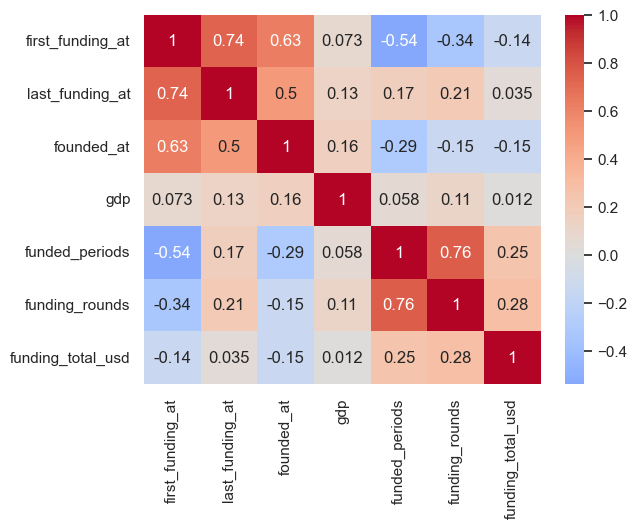

In [15]:
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Show the plot
plt.show()

Based on the correlation matrix and heatmap we can conclude that our target variable is positively correlated with our additional feature 'funded periods' and 'gdp'. Hence, we decided to leave in the two features for the our following models.

## The Modelling Process

For the development of each model, we created a single training/testing data set to ensure each model is trained and tested with the same data. The training/test data sets are split into a ratio of 70/30 (70% training and 30% testing to ensure enough data for both the training and testing. The training dataset is divided into the pre-processed data without the total funding (‘x_train’) and the training data containing the target_variable (‘y_train’).

During the modeling process we follow the three steps:
1. Train the model (model parameters)
2. Validate the model (model choice, hyperparameters)
3. Test the model (on holdout testdata)

In [16]:
#Create the training data sets (y_training = target variable) and split into test/training data
x_training = training.drop(columns=['funding_total_usd'],axis = 1)
y_training = training['funding_total_usd']
x_train, x_val, y_train, y_val = train_test_split(x_training, y_training, test_size=0.3, random_state=50)
x_training[6:10]

,funding_rounds,founded_at,first_funding_at,last_funding_at,funded_periods,gdp,market_ 3D,market_ 3D Printing,market_ 3D Technology,market_ Accounting,...,state_code_SK,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
1,1,2012,2012,2012,0,2.304386e+10,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2012,2012,2012,0,2.304386e+10,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2012,2012,2012,0,2.304386e+10,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2012,2012,2012,0,2.304386e+10,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
y_training

0         1750000.0
0         1750000.0
0         1750000.0
0         1750000.0
0         1750000.0
            ...    
28727       97398.0
28727       97398.0
28728    45000000.0
28728    45000000.0
28728    45000000.0
Name: funding_total_usd, Length: 123277, dtype: float64

### Linear Regression

For the linear regression we only included the features that are positively correlated to our target varialbe 'funding_total_usd'. Therefore, we created new X_lr and y_lr and split the dataset into again into Training-Test-Data for the GridSearchCV. The reasoning behind this approach is that the categorical variables were transformed into numeric variables via One-Hot-Encoding in the previous process, which highly increased the dimensionality of the dataset as well as number of features for the linear regression.

Note: The session crashed several times when trying to fit the linear regression model using x_train and y_train, hence we included only variables of numeric nature and positive correlation with the target variable into our linear regression.

In [18]:
X_lr = training [['funded_periods','funding_rounds','last_funding_at','gdp']]

y_lr = training['funding_total_usd']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state=50)

In [19]:
# Define the linear regression model
lr = LinearRegression()

# Define the hyperparameters to search
param_grid = {
    'fit_intercept': [True, False]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=10)

grid_search.fit(X_train_lr, y_train_lr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START fit_intercept=True..........................................
[CV 1/5; 1/2] END fit_intercept=True;, score=-4716398552216482.000 total time=   0.0s
[CV 2/5; 1/2] START fit_intercept=True..........................................
[CV 2/5; 1/2] END fit_intercept=True;, score=-2117765442310127.500 total time=   0.0s
[CV 3/5; 1/2] START fit_intercept=True..........................................
[CV 3/5; 1/2] END fit_intercept=True;, score=-6604480936829499.000 total time=   0.0s
[CV 4/5; 1/2] START fit_intercept=True..........................................
[CV 4/5; 1/2] END fit_intercept=True;, score=-3642080801634313.000 total time=   0.0s
[CV 5/5; 1/2] START fit_intercept=True..........................................
[CV 5/5; 1/2] END fit_intercept=True;, score=-8452978477656891.000 total time=   0.0s
[CV 1/5; 2/2] START fit_intercept=False.........................................
[CV 1/5; 2/2] END fit_in

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error', verbose=10)

In [20]:
# Show mean squared error of best estimator model

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score (RMSE): {:.2f}".format(np.sqrt(-grid_search.best_score_)))

Best parameters: {'fit_intercept': True}
Best cross-validation score (RMSE): 71461464.04


In [21]:
# Show test set metrics

best_model = grid_search.best_estimator_
y_pred_lr = best_model.predict(X_test_lr)

mse = mean_squared_error(y_test_lr, y_pred_lr)
print("Mean Squared Error: {:.2f}".format(mse))
mae = mean_absolute_error(y_test_lr, y_pred_lr)
print("Mean Absolute Error: {:.2f}".format(mae))
rmse = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
print("Root Mean Squared Error: {:.2f}".format(rmse))
r2 = r2_score(y_test_lr, y_pred_lr)
print("R2 Score: {:.2f}".format(r2))

Mean Squared Error: 3634838280631913.00
Mean Absolute Error: 16346710.28
Root Mean Squared Error: 60289620.01
R2 Score: 0.11


### Decision Tree Regression

In [22]:
# Create a Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=50)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [23]:
# Perform a grid search with 5-fold cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 10, n_jobs =-1)

In [24]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=50), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=10)

In [25]:
# Print the best hyperparameters found by the grid search and RMSE
print("Best hyperparameters: {}".format(grid_search.best_params_))
print("Best cross-validation score (RMSE): {:.2f}".format(np.sqrt(-grid_search.best_score_)))

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score (RMSE): 42066892.27


In [26]:
# Show test set metrics
best_tree = grid_search.best_estimator_
y_pred_tree = best_tree.predict(x_val)

mse = mean_squared_error(y_val, y_pred_tree)
print("Mean squared error: {:.2f}".format(mse))
mae = mean_absolute_error(y_val, y_pred_tree)
print("Absolute Error: {:.2f}".format(mae))
rmse = np.sqrt(mean_squared_error(y_val, y_pred_tree))
print("Root Mean Squared Error: {:.2f}".format(rmse))
r2 = r2_score(y_val, y_pred_tree)
print("R2 score: {:.2f}".format(r2))

Mean squared error: 892334010315882.38
Absolute Error: 10184829.52
Root Mean Squared Error: 29871960.27
R2 score: 0.78


### Random Forest Regression


Previously, we used a decision tree for making predictions of the target variable (funding_total_usd). However, decision trees are more prone to overfitting, which is a common issue with decision trees. This can often lead to poor performance or inaccurate predictions due to its poor generalization ability. To avoid this, we will be using Random Forest, which is an ensemble method that uses a combination of multiple decision trees to make predictions. 

### Parameter Tuning Random Forest
Due to the large dataset, we limited the GridSearch for the Random Forest cross validation. Although the gridsearch indicated a 'max_depth' of 7, we have decidede to tune it down to 5 to control the depth of the trees, as a, increased depth could result in overfitting. Gridsearch indicated that 'n_estimators' would be best set at 150. However, considering after manually tuning the parameters, we decided that 300 would be the best value for the 'n_estimator' parameter. Higher value for 'n_estimator' parameter requires longer computational times, which also affected the cross validation run time.

### XGBoost
Another popular ensemble method is gradient boosting. We will be using XGBoost (Extreme Gradient Boosting), which works similarly to Random Forest. XGBoost works by building a series of decision trees, where each tree is built to correct the errors of the previous tree. The reason for the using XGBoost is its speed and scalability. This is especially noticed when using the same parameters from the Random Forest. Morever, it has yielded a far higher R2 score of 0.82, with n_estimators = 300. However, when doing the cross-validation, 2 fits out of 5 failed. Therefore, the XBGoost might not be reliable for this dataset. 

In [27]:
# Random Forest Model
rf_final = RandomForestRegressor(n_estimators=300, max_depth=5, n_jobs=-1)
rf_final.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=300, n_jobs=-1)

In [28]:
# Check the R2-test score
rf_final.score(x_val, y_val)

0.3883112318528873

In [29]:
# Cross-validation 5-fold
rfscores = cross_val_score(rf_final, x_train, y_train, cv=5, n_jobs = -1)

In [30]:
# Cross validated mean score
rfscores.mean()

0.37572408827893927

In [31]:
y_pred_rf_final = rf_final.predict(x_val)

In [32]:
# Calculate the MSE, MAE, RMSE and R2
mse_rf_final = mean_squared_error(y_val, y_pred_rf_final)
print("Mean Squared Error (MSE): {:.2f}".format(mse_rf_final))
mae_rf_final = mean_absolute_error(y_val, y_pred_rf_final)
print("Absolute error (MAE): {:.2f}".format(mae_rf_final))
rmse_rf_final = np.sqrt(mean_squared_error(y_val, y_pred_rf_final))
print("Root Mean Squared Error: {:.2f}".format(rmse_rf_final))
r2_rf_final = r2_score(y_val, y_pred_rf_final)
print("R2 Score: {:.2f}".format(r2_rf_final))

Mean Squared Error (MSE): 2486599278833580.50
Absolute error (MAE): 14561288.22
Root Mean Squared Error: 49865812.73
R2 Score: 0.39


Using Gridsearch for RandomForest

In [33]:
# First hyperparameter tuning with basic grid

# Define the random forest regressor
rf = RandomForestRegressor()

# Define the hyperparameters to search
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 5, 7],
}

# Perform grid search with 5-fold cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv = 5, scoring='neg_mean_squared_error', verbose=10, n_jobs = -1)

In [34]:
grid_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=10)

In [35]:
# Show mean squared error of best estimator model
print("Best parameters: {}".format(grid_search_rf.best_params_))
print("Best cross-validation score (RMSE): {:.2f}".format(np.sqrt(-grid_search_rf.best_score_)))

Best parameters: {'max_depth': 7, 'n_estimators': 150}
Best cross-validation score (RMSE): 53533653.51


In [36]:
# Show test set metrics
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(x_val)

# Calculate the MSE, MAE, RMSE and R2
mse_rf = mean_squared_error(y_val, y_pred_rf)
print("Mean Squared Error (MSE): {:.2f}".format(mse_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)
print("Absolute error (MAE): {:.2f}".format(mae_rf))
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
print("Root Mean Squared Error: {:.2f}".format(rmse_rf))
r2_rf = r2_score(y_val, y_pred_rf)
print("R2 Score: {:.2f}".format(r2_rf))

Mean Squared Error (MSE): 2112291589190658.50
Absolute error (MAE): 13872170.65
Root Mean Squared Error: 45959673.51
R2 Score: 0.48


### XGBoost

In [37]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=5, learning_rate=0.1, subsample=0.5, colsample_bytree=0.5, n_jobs=-1)
xgb_model.fit(x_train, y_train)
xgb_score = xgb_model.score(x_train, y_train)
print(xgb_score)

y_pred_XGB = xgb_model.predict(x_val)
y_pred_XGB

# Calculate the MSE, MAE, RMSE and R2
mse_XGB = mean_squared_error(y_val, y_pred_XGB)
print("Mean Squared Error (MSE): {:.2f}".format(mse_XGB))
mae_XGB = mean_absolute_error(y_val, y_pred_XGB)
print("Absolute error (MAE): {:.2f}".format(mae_XGB))
rmse_XGB = np.sqrt(mean_squared_error(y_val, y_pred_XGB))
print("Root Mean Squared Error: {:.2f}".format(rmse_XGB))
r2_XGB = r2_score(y_val, y_pred_XGB)
print("R2 Score: {:.2f}".format(r2_XGB))

0.785608511491954
Mean Squared Error (MSE): 1456768590322527.50
Absolute error (MAE): 12210916.23
Root Mean Squared Error: 38167638.00
R2 Score: 0.64


### Random Forest Regression and XGBoost Comparison

In [38]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# create a Random Forest Regressor with 20 trees and a max depth of 5
rf_test = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=50, n_jobs=-1)

# fit the model on the training data
rf_test.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=20, n_jobs=-1, random_state=50)

In [39]:
from sklearn.model_selection import cross_val_score
scores_RF = cross_val_score(rf_test, x_train, y_train, cv=5, n_jobs=-1) 
scores_RF

array([0.34212503, 0.18998605, 0.4330645 , 0.31153745, 0.52921891])

In [40]:
xgb_test_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.5, colsample_bytree=0.5, n_jobs=-1)
xgb_test_model.fit(x_train, y_train)
xgb_test_score = xgb_test_model.score(x_train, y_train)
print(xgb_score)

0.785608511491954


### Gradient Boosting Model 

Since the dataset uses a continuous target variable (funding_total_usd), we made use of the ensemble method Gradient Boost Regressor as the machine learning algorithm for the regression problem. Since it is a boosting algorithm, the core purpose of this model is improving the accuracy based on the errors in the previous models. In the end, it would result in a much more accurate models than simpler methods such as the Decision Tree model.

### Parameter Tuning
After performing the gridsearch function, we would acquire the best results for the 'learning rate' at 0.5, however since a large learning rate could result into overfitting, we have decided to tune it down a bit and lower the parameter to improve the generalization performance of the model for other test data. Although a learning rate between 0.01 and 0.1 might be ideal, it would ultimately result into an increase in computational time for the model, making it difficult to run. For the 'max_depth' parameter, we have decided to settle down at max_depth = 5 to control the depth of the trees. Just like the learning_rate parameter, the an increase in max_depth could further risk the chances of overfitting, resulting in difficulty of generalization with new test data. Moreover, since increasing the depth of the trees would result in more complexity, additional computational time is required and this would be difficult to achieve especially with a cross-validation of 5-folds.

The last parameter tuned for the model is the 'n_estimators', which refer to the amount of decision trees created in the Gradient Boost Regressor. Since the performance starts to drop down after a certain threshold, the risk of overfitting is not quite as big compared to the previous parameters. The biggest risk in this case would be the computational time required to run the code. Running the model for the test score results in the highest R2 score of 0.81 with n_estimators = 1000, however the 5-fold cross-validation mean sits around R2 = 0.68

In [41]:
# Gradient Boosting Regressor model
gbrfinal = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.2, max_depth=5, random_state=50)
gbrfinal.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=1000,
                          random_state=50)

In [42]:
# Check the R2-test score
gbrfinal.score(x_val, y_val)

0.8362456590954112

In [43]:
# Cross-validation 5-fold
gbrscores = cross_val_score(gbrfinal, x_train, y_train, cv=5, n_jobs = -1)

In [44]:
# Cross validated mean score
gbrscores.mean()

0.7231415420735471

In [45]:
y_pred_gbrfinal = gbrfinal.predict(x_val)

In [46]:
# Calculate the MSE, MAE, RMSE and R2
mse = mean_squared_error(y_val, y_pred_gbrfinal)
print("Mean Squared Error (MSE): {:.2f}".format(mse))
mae = mean_absolute_error(y_val, y_pred_gbrfinal)
print("Absolute error (MAE): {:.2f}".format(mae))
rmse = np.sqrt(mean_squared_error(y_val, y_pred_gbrfinal))
print("Root Mean Squared Error: {:.2f}".format(rmse))
r2 = r2_score(y_val, y_pred_gbrfinal)
print("R2 Score: {:.2f}".format(r2))

Mean Squared Error (MSE): 665684000104589.50
Absolute error (MAE): 8592051.78
Root Mean Squared Error: 25800852.70
R2 Score: 0.84


### Gradient Boost Comparison


In [47]:
# Gradient Boosting Regressor model
testgbr = GradientBoostingRegressor(n_estimators= 20, learning_rate=0.2, max_depth=5, random_state=50)

from sklearn.model_selection import cross_val_score
testscores = cross_val_score(testgbr, x_train, y_train, cv=5) #n_estimators= 20, learning_rate=0.1, max_depth=5, random_state=50

testgbr.fit(x_train, y_train)


GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=20,
                          random_state=50)

In [48]:
test_score1 = testgbr.score(x_val, y_val) #n_estimators= 20, learning_rate=0.2, max_depth=5, random_state=50
test_score1 

0.5437608702602479

In [49]:
# Cross-validated 5-fold mean
testscores.mean()

0.4946490074743771

### Conclusion
An essential step in our process is model evaluation, which helps us better understand the performance of our models. By using different metrics for our evaluation, we aspire to make the most comprehensive choice based on numbers. 
Since our target variable is continuous, we have used regression models, namely Linear Regression, Decision Tree Regressor, Gradient Boosting Regressor, and the Random Forest Regressor from the scikit-learn library.

For the interpretation of the scores, we took several measures to support the model performance. The R2-score is the basis for the performance measure. It measures proportion of variance that is predictable by using the independent variables and showcases the fit with the dataset. Although this measurement method is most commonly used and preferred, it is not sufficient in the evaluation of the model’s performance. Whereas R2 is a number between 0 and 1 and a bigger number indicates a better explanation of the target variable by our models, a smaller of MSE/RMSE and MAE indicate the better performance of a model. Therefore, the Mean Squared Error is used to measure the average squared differences between the values predicted by the model and the actual data values. To make these numbers more interpretable, the Root Mean Squared Error (RMSE) is used to convert the values into the same unit as the target variable (USD). Moreover, Mean Absolute Error (MAE) is included to measure the absolute differences instead of squared differences alone (Chai & Draxler, 2014; Karunasingha, 2022).

Using these metrics to evaluate our models, we conclude that our best performing model is the Gradient Boosting Regressor model. It distributes the highest R2, 0.84, while showing lower values in MSE/RMSE and MAE, 25800852.70 (RMSE), in comparison to other models.

### Bibliography
- Chai, T., & Draxler, R. R. (2014). Root mean square error (RMSE) or mean absolute error (MAE)?–Arguments against avoiding RMSE in the literature. Geoscientific model development, 7(3), 1247-1250.
- Karunasingha, D. S. K. (2022). Root mean square error or mean absolute error? Use their ratio as well. Information Sciences, 585, 609-629.
- World Bank Open Data. (n.d.). GDP (current US$) [Data set]. World Bank Open Data. https://data.worldbank.org/indicator/NY.GDP.MKTP.CD